In [1]:
# Import usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling library
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.dummy import DummyRegressor # (baseline score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV

# Using this code bit only to make the notebook cleaner to read
# through. 
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

pd.options.mode.chained_assignment = None  # default='warn'

import itertools as it
from sklearn.preprocessing import StandardScaler

In [9]:
df_num = pd.read_csv('./datasets/train_clean_num.csv')

In [10]:
df_num.head(5)

,ms_subclass,lot_frontage,lot_area,overall_quality,overall_condition,year_built,masonry_area,ground_living_sf,bedroom_above_ground,kitchen_above_ground,...,garage_cars,month_sold,year_sold,sale_price,has_basement_sf,has_2nd_floor_sf,all_bath,has_open_porch,has_fireplace,has_wood_deck
0,20,80.000000,9605,7,6,2007,0.0,1218,3,1,...,2.0,4,2009,159000,1,0,1.5,1,0,0
1,20,90.000000,14684,7,7,1990,234.0,2196,3,1,...,3.0,6,2009,271900,1,0,2.0,1,1,1
2,20,69.549319,14375,6,6,1958,541.0,1344,3,1,...,2.0,1,2009,137500,1,0,1.5,1,1,0
3,120,48.000000,6472,9,5,2008,500.0,1456,2,1,...,2.0,4,2009,248500,1,0,2.0,1,1,1
4,80,61.000000,9734,7,5,2004,0.0,1374,3,1,...,2.0,5,2009,167000,1,1,2.5,0,0,0


In [11]:
df_num.isnull().mean()[df.isnull().mean()>0]

Series([], dtype: float64)

In [4]:
# clean fireplace
df['fireplace_quality'].fillna('NA',inplace=True)

In [5]:
# Impute values that represent no basement
df['basement_quality'].fillna('NA',inplace=True)
df['basement_condition'].fillna('NA',inplace=True)
df['basement_exposure'].fillna('NA',inplace=True)
df['basement_fin_type_1'].fillna('NA',inplace=True)
df['basement_fin_type_2'].fillna('NA',inplace=True)
df['basement_fin_sf_1'].fillna(0,inplace=True) #mode
df['basement_fin_sf_2'].fillna(0,inplace=True) #mode
df['basement_unf_sf'].fillna(0,inplace=True) #mode
df['basement_full_bath'].fillna(0,inplace=True)
df['basement_half_bath'].fillna(0,inplace=True)
df['total_basement_sf'].fillna(0,inplace=True)

In [6]:
# impute garage type as missing values
df['garage_type'].fillna('NA',inplace=True)
df['garage_year_built'].fillna(df['year_built'],inplace=True)
df['garage_fin'].fillna('NA',inplace=True)
df['garage_quality'].fillna('NA',inplace=True)
df['garage_condition'].fillna('NA',inplace=True)
df['garage_cars'].fillna(0,inplace=True)
df['garage_area'].fillna(0,inplace=True)

In [7]:
df.isnull().mean()[df.isnull().mean()>0]

Series([], dtype: float64)

<AxesSubplot:xlabel='sale_price', ylabel='Count'>

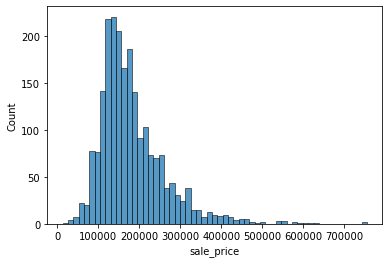

In [8]:
sns.histplot(x='sale_price',data=df)

In [9]:
df['year_built'] = df['year_built'].apply(lambda x : str(x))

In [10]:
df['year_sold'] = df['year_sold'].apply(lambda x : str(x))

In [11]:
#df = df[df['sale_price'] < 600000]

In [12]:
df.shape

(2197, 78)

In [13]:
# Create option to remove outlier

## EDA

Separate into numerical and categorical columns

In [14]:
# Separte to categorical column
df_cat = df.select_dtypes(include=object)

In [15]:
# Separate to numerical column
df_num = df.select_dtypes(exclude=object)

In [16]:
# Investigate correlation with log_sale_price

df['log_sale_price'] = df['sale_price'].apply(np.log)
df_num['log_sale_price'] = df['log_sale_price']

In [17]:
# Add sale price to categorical column
df_cat['sale_price'] = df['sale_price']
df_cat['log_sale_price'] = df['log_sale_price']

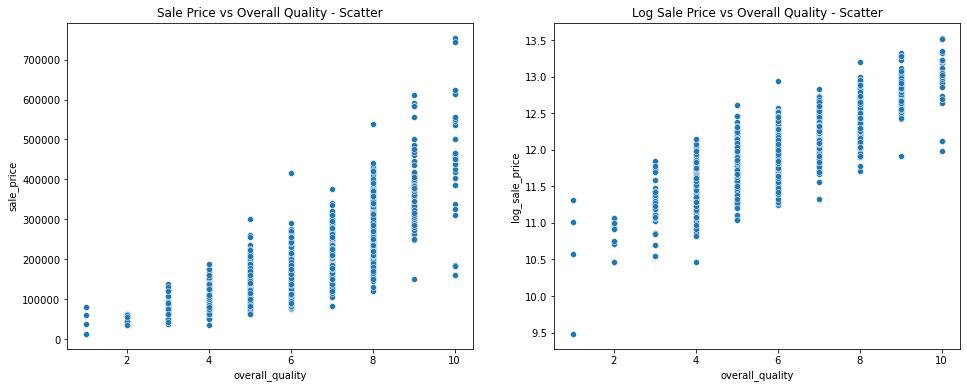

In [18]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].set_title('Sale Price vs Overall Quality - Scatter')
ax[1].set_title('Log Sale Price vs Overall Quality - Scatter')

sns.scatterplot(x='overall_quality',y='sale_price',data=df_num,ax=ax[0])
sns.scatterplot(x='overall_quality',y='log_sale_price',data=df_num,ax=ax[1]);

Numerical Columns

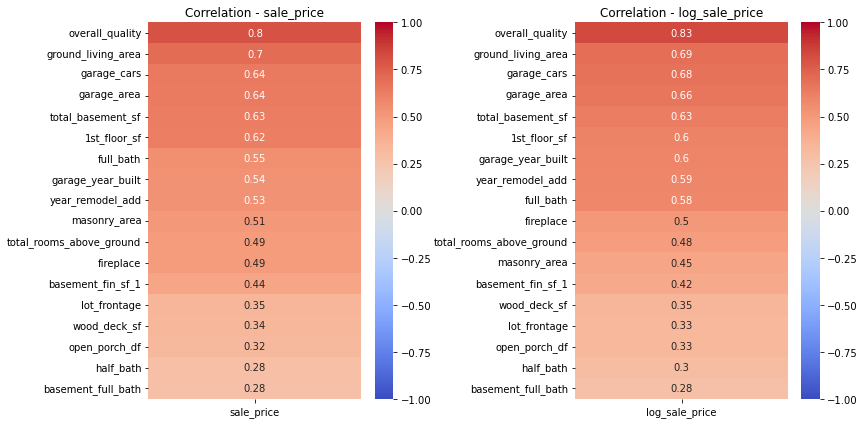

In [19]:
# check correlation with sale_price - select top 20 (negative correlation is not significant here)

fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.heatmap(df_num.corr()[['sale_price']].sort_values(by='sale_price',ascending=False).head(20)[2:],
            ax=ax[0],
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1
           ).set_title('Correlation - sale_price')
sns.heatmap(df_num.corr()[['log_sale_price']].sort_values(by='log_sale_price',ascending=False).head(20)[2:],
            ax=ax[1],
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1
           ).set_title('Correlation - log_sale_price')

plt.tight_layout();

In [13]:
# Use LASSO Regression to identify key columns against log_sale_price
# Separate X and y
X = df_num.drop(columns=['sale_price'])
y = df_num['sale_price']

In [14]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [23]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(0,10,100)

In [24]:
# Cross-validate over our list of Lasso alphas
lasso_cv = LassoCV(alphas=l_alphas)

In [25]:
# log transform
# y_train_log = y_train.apply(np.log)

In [26]:
# Fit model using best LASSO alpha!
lasso_cv.fit(Z_train, y_train)

LassoCV(alphas=array([1.00000000e+00, 1.26185688e+00, 1.59228279e+00, 2.00923300e+00,
       2.53536449e+00, 3.19926714e+00, 4.03701726e+00, 5.09413801e+00,
       6.42807312e+00, 8.11130831e+00, 1.02353102e+01, 1.29154967e+01,
       1.62975083e+01, 2.05651231e+01, 2.59502421e+01, 3.27454916e+01,
       4.13201240e+01, 5.21400829e+01, 6.57933225e+01, 8.30217568e+01,
       1.04761575e+02, 1.32194115e+0...
       4.75081016e+07, 5.99484250e+07, 7.56463328e+07, 9.54548457e+07,
       1.20450354e+08, 1.51991108e+08, 1.91791026e+08, 2.42012826e+08,
       3.05385551e+08, 3.85352859e+08, 4.86260158e+08, 6.13590727e+08,
       7.74263683e+08, 9.77009957e+08, 1.23284674e+09, 1.55567614e+09,
       1.96304065e+09, 2.47707636e+09, 3.12571585e+09, 3.94420606e+09,
       4.97702356e+09, 6.28029144e+09, 7.92482898e+09, 1.00000000e+10]))

In [27]:
# Find best alpha
l_alpha = lasso_cv.alpha_
l_alpha

2154.4346900318847

In [28]:
# reassign optimal alpha to Lasso
lasso = Lasso(alpha=l_alpha)

In [29]:
# fit lasso
lasso.fit(Z_train, y_train)

Lasso(alpha=2154.4346900318847)

In [30]:
# predict
y_train_preds = lasso.predict(Z_train)
y_test_preds = lasso.predict(Z_test)

# convert exponential back to USD
# y_train_preds = np.exp(y_train_preds_log)
# y_test_preds = np.exp(y_test_preds_log)

In [31]:
# coef
lasso_coefs = lasso_cv.coef_

In [32]:
# coef in pd
lasso_coefs = pd.Series(lasso_coefs, X.columns)

In [33]:
print(f"Training score: {lasso.score(Z_train,y_train)}")
print(f"Testing score: {lasso.score(Z_test,y_test)}")
print(f"RMSE train score: {round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)}")
print(f"RMSE test score: {round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)}")

Training score: 0.8157493237862893
Testing score: 0.8149842729048026
RMSE train score: 34841.72
RMSE test score: 34880.76


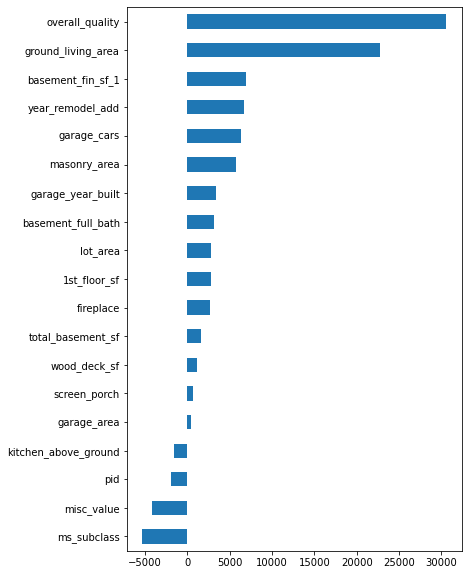

In [34]:
plt.figure(figsize=(6,10))
lasso_coefs[lasso_coefs != 0].sort_values(ascending=True).plot.barh();

In [35]:
lasso_cols = lasso_coefs[lasso_coefs != 0].sort_values(ascending=False).head(15).index
lasso_cols

Index(['overall_quality', 'ground_living_area', 'basement_fin_sf_1',
       'year_remodel_add', 'garage_cars', 'masonry_area', 'garage_year_built',
       'basement_full_bath', 'lot_area', '1st_floor_sf', 'fireplace',
       'total_basement_sf', 'wood_deck_sf', 'screen_porch', 'garage_area'],
      dtype='object')

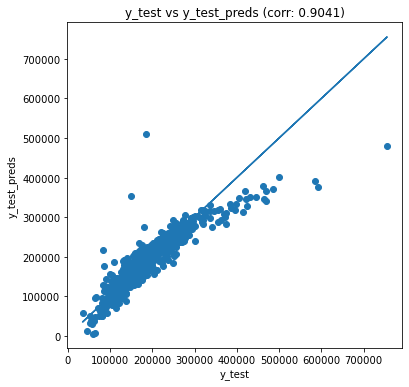

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(y=y_test_preds,x=y_test)
plt.plot(y_test,y_test)
cor = np.corrcoef(y_test_preds,y_test)
plt.xlabel('y_test')
plt.ylabel('y_test_preds')
plt.title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})");

Categorical column

In [37]:
df_cat['log_sale_price'] = df_num['log_sale_price']

In [38]:
df_cat.head(5)

,ms_zoning,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,...,garage_type,garage_fin,garage_quality,garage_condition,paved_drive,year_sold,sale_type,Sale Condition,sale_price,log_sale_price
0,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,...,Detchd,RFn,TA,TA,Y,2009,WD,Normal,159000,11.976659
1,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,...,Attchd,RFn,TA,TA,Y,2009,WD,Normal,271900,12.513190
2,RL,Pave,IR1,Lvl,NoSeWa,CulDSac,Gtl,Timber,Norm,Norm,...,Basment,RFn,TA,TA,Y,2009,COD,Abnorml,137500,11.831379
3,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,...,Attchd,RFn,TA,TA,Y,2009,WD,Normal,248500,12.423198
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,...,BuiltIn,Fin,TA,TA,Y,2009,WD,Normal,167000,12.025749


In [39]:
# reset cat cols to combine get new column
df_cat = df.select_dtypes(include=object)

In [40]:
cat_col = df_cat.columns

In [41]:
cat_col

Index(['ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'building_type', 'house_style', 'year_built',
       'roof_style', 'roof_material', 'exterior_1', 'exterior_2',
       'masonry_type', 'external_quality', 'external_condition', 'foundation',
       'basement_quality', 'basement_condition', 'basement_exposure',
       'basement_fin_type_1', 'basement_fin_type_2', 'heating', 'heating_qc',
       'central_air', 'electrical', 'kitchen_quality', 'functional',
       'fireplace_quality', 'garage_type', 'garage_fin', 'garage_quality',
       'garage_condition', 'paved_drive', 'year_sold', 'sale_type',
       'Sale Condition'],
      dtype='object')

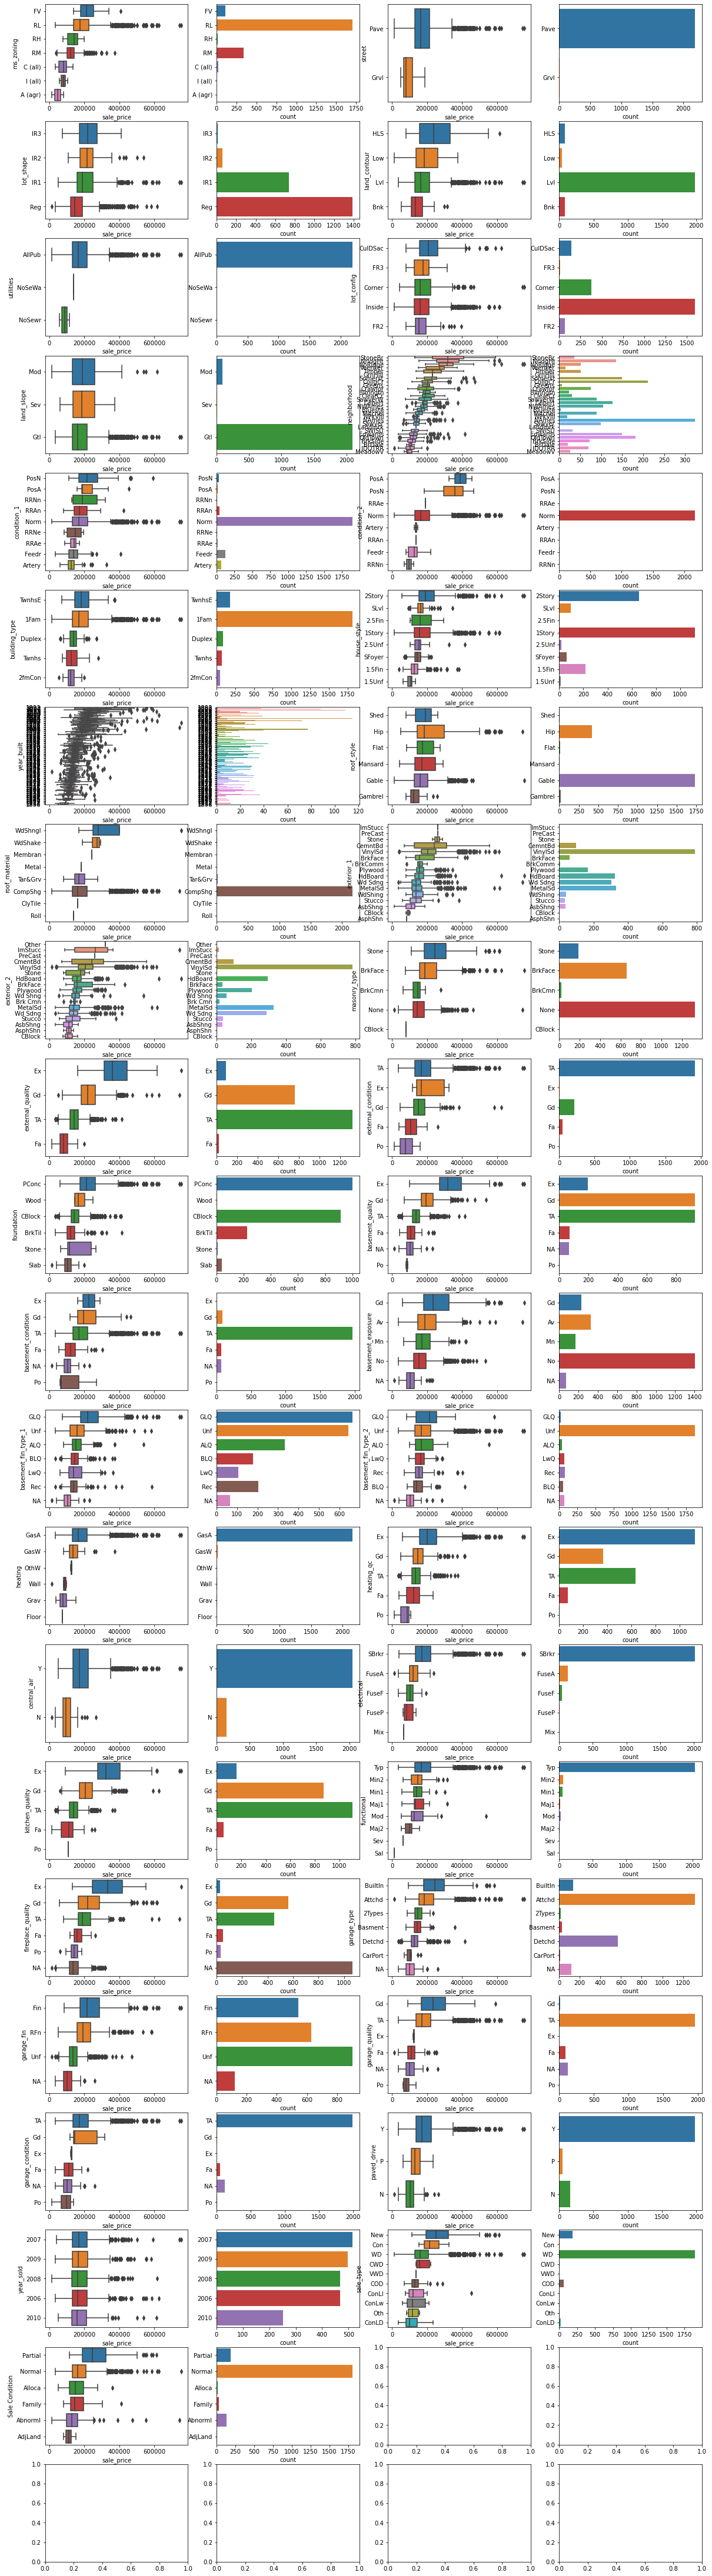

In [44]:
fig, axes = plt.subplots(22, 4, figsize=(20,80)) ## 16 rows * 4 columns

for i, feat in enumerate(cat_col): ## iterate column name
    x = i // 2  ## row index
    y = 2*i % 4  ## column index
    plot1 = sns.boxplot(
        ax=axes[x,y],
        y=feat,
        x='sale_price',
        orient='h',
        order=df.groupby(feat)['sale_price'].median().sort_values(ascending=False).index,
        data=df)
    plot2 = sns.countplot(
        ax=axes[x,y+1],
        y=feat,
        order=df.groupby(feat)['sale_price'].median().sort_values(ascending=False).index, ## only top10
        data=df)
    plot2.set(ylabel=None) ## show ylabel only boxplot 

In [45]:
# garage finishing can combine NA with Unf

#### Feature engineering

OverallQual: Overall material and finish quality
- 10 Very Excellent
- 9 Excellent
- 8 Very Good
- 7 Good
- 6 Above Average
- 5 Average
- 4 Below Average
- 3 Fair
- 2 Poor
- 1 Very Poor

Can map with overall condition
- Ex - 9
- Gd - 7
- TA - 5
- Fa - 3
- Po - 1

We will use this criteria to apply to other features

In [46]:
#def convert_cat_to_num(string):
    #cat_num_dict = {'Ex':9,'Gd':7,'TA':5,'Fa':3,'Po':1,'NA':3}
    #num = cat_num_dict[string]
    #return num

In [47]:
# Combine lot shape
df['lot_shape_group'] = df['lot_shape'].apply(lambda x : x if x == 'Reg' else 'IR')

In [48]:
# combine some category
df['basement_exposure'] = df['basement_exposure'].apply(lambda x : 'No' if x == 'NA' else x)

In [49]:
df['heating_qc'] = df['heating_qc'].apply(lambda x : 'Fa' if x == 'Po' else x)

In [50]:
df['kitchen_quality'] = df['kitchen_quality'].apply(lambda x : 'Fa' if x == 'Po' else x)

In [51]:
df['garage_fin'] = df['garage_fin'].apply(lambda x : 'Unf' if x == 'NA' else x)

---

Add new numerical columns

In [52]:
# Separate to numerical column
df_num = df.select_dtypes(exclude=object)

In [53]:
X_poly = df_num.drop(columns=['sale_price','log_sale_price'])

In [54]:
features = list(X_poly.columns)

In [55]:
X_poly

,Order,pid,ms_subclass,lot_frontage,lot_area,overall_quality,overall_condition,year_remodel_add,masonry_area,basement_fin_sf_1,...,garage_cars,garage_area,wood_deck_sf,open_porch_df,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_value,month_sold
0,534,531363010,20,80.000000,9605,7,6,2007,0.0,0.0,...,2.0,576.0,0,178,0,0,0,0,0,4
1,803,906203120,20,90.000000,14684,7,7,1991,234.0,485.0,...,3.0,701.0,84,70,0,0,0,0,0,6
2,956,916176030,20,69.549319,14375,6,6,1958,541.0,111.0,...,2.0,525.0,0,118,0,0,233,0,0,1
3,460,528180130,120,48.000000,6472,9,5,2008,500.0,0.0,...,2.0,539.0,192,42,0,0,0,0,0,4
4,487,528290030,80,61.000000,9734,7,5,2004,0.0,241.0,...,2.0,400.0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,2764,906420020,60,80.000000,10041,8,5,1992,0.0,789.0,...,2.0,506.0,120,150,0,0,0,0,0,2
2193,906,909129090,50,70.000000,6300,5,4,1950,88.0,832.0,...,1.0,250.0,0,0,55,0,0,0,0,7
2194,1097,528292060,60,41.000000,12460,7,5,2000,0.0,870.0,...,2.0,400.0,144,44,0,0,0,0,0,5
2195,236,905426060,30,85.000000,10625,5,5,1950,0.0,108.0,...,1.0,366.0,0,0,77,0,0,0,400,5


In [56]:
poly = PolynomialFeatures(include_bias=False) 
X_poly = poly.fit_transform(X_poly)

In [57]:
X_poly.shape

(2197, 702)

In [58]:
poly.get_feature_names_out(features)

array(['Order', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area',
       'overall_quality', 'overall_condition', 'year_remodel_add',
       'masonry_area', 'basement_fin_sf_1', 'basement_fin_sf_2',
       'basement_unf_sf', 'total_basement_sf', '1st_floor_sf',
       '2nd_floor_sf', 'low_quality_fin_sf', 'ground_living_area',
       'basement_full_bath', 'basement_half_bath', 'full_bath',
       'half_bath', 'bed_above_ground', 'kitchen_above_ground',
       'total_rooms_above_ground', 'fireplace', 'garage_year_built',
       'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_df',
       'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area',
       'misc_value', 'month_sold', 'Order^2', 'Order pid',
       'Order ms_subclass', 'Order lot_frontage', 'Order lot_area',
       'Order overall_quality', 'Order overall_condition',
       'Order year_remodel_add', 'Order masonry_area',
       'Order basement_fin_sf_1', 'Order basement_fin_sf_2',
       'Order basement_unf_sf', 'Or

In [59]:
poly_df = pd.DataFrame(X_poly,columns=poly.get_feature_names_out(features))
poly_df.head()

,Order,pid,ms_subclass,lot_frontage,lot_area,overall_quality,overall_condition,year_remodel_add,masonry_area,basement_fin_sf_1,...,screen_porch^2,screen_porch pool_area,screen_porch misc_value,screen_porch month_sold,pool_area^2,pool_area misc_value,pool_area month_sold,misc_value^2,misc_value month_sold,month_sold^2
0,534.0,531363010.0,20.0,80.000000,9605.0,7.0,6.0,2007.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
1,803.0,906203120.0,20.0,90.000000,14684.0,7.0,7.0,1991.0,234.0,485.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0
2,956.0,916176030.0,20.0,69.549319,14375.0,6.0,6.0,1958.0,541.0,111.0,...,54289.0,0.0,0.0,233.0,0.0,0.0,0.0,0.0,0.0,1.0
3,460.0,528180130.0,120.0,48.000000,6472.0,9.0,5.0,2008.0,500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
4,487.0,528290030.0,80.0,61.000000,9734.0,7.0,5.0,2004.0,0.0,241.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0


In [60]:
poly_df['sale_price'] = df['sale_price']
poly_df['log_sale_price'] = df['log_sale_price']

In [61]:
# no. of features to select
num_feat = 122

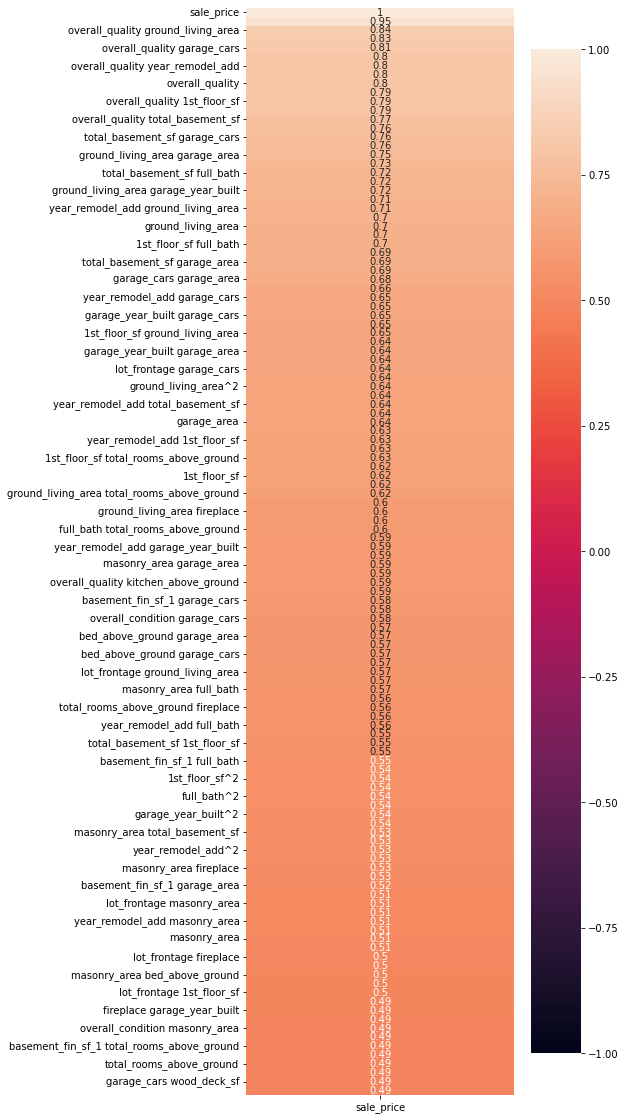

In [62]:
plt.figure(figsize = (6,20))
sns.heatmap(poly_df.corr()[['sale_price']].sort_values('sale_price',ascending=False).head(num_feat),
            annot=True,vmin=-1,vmax=1);

In [63]:
poly_selected_cols = poly_df[list(poly_df.corr()[['sale_price']]\
                                  .sort_values('sale_price',ascending=False)[:num_feat].index)]

In [64]:
poly_selected_cols.columns

Index(['sale_price', 'log_sale_price', 'overall_quality ground_living_area',
       'overall_quality^2', 'overall_quality garage_cars',
       'overall_quality garage_year_built', 'overall_quality year_remodel_add',
       'overall_quality garage_area', 'overall_quality',
       'ground_living_area garage_cars',
       ...
       'fireplace garage_year_built', '1st_floor_sf bed_above_ground',
       'overall_condition masonry_area', 'year_remodel_add fireplace',
       'basement_fin_sf_1 total_rooms_above_ground',
       'lot_frontage total_basement_sf', 'total_rooms_above_ground',
       'kitchen_above_ground garage_cars', 'garage_cars wood_deck_sf',
       'fireplace'],
      dtype='object', length=122)

In [65]:
# lot shape group doesn't really help
# poly_selected_cols['lot_shape_group'] = df['lot_shape_group']
poly_selected_cols['external_quality'] = df['external_quality']
poly_selected_cols['heating_qc'] = df['heating_qc']
poly_selected_cols['kitchen_quality'] = df['kitchen_quality']
poly_selected_cols['garage_fin'] = df['garage_fin']

In [66]:
# Use LASSO Regression to identify key columns against log_sale_price
# Separate X and y
X = poly_selected_cols.drop(columns=['sale_price','log_sale_price'])
y = poly_selected_cols['sale_price']

In [67]:
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)

In [68]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
#y_train_log = np.log(y_train)
#y_test_log = np.log(y_test)

In [70]:
# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [71]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-4,10,100)

In [72]:
# Cross-validate over our list of Lasso alphas
lasso_cv = LassoCV(alphas=l_alphas)

In [73]:
# Fit model using best LASSO alpha!
lasso_cv.fit(Z_train, y_train)

LassoCV(alphas=array([1.00000000e-04, 1.38488637e-04, 1.91791026e-04, 2.65608778e-04,
       3.67837977e-04, 5.09413801e-04, 7.05480231e-04, 9.77009957e-04,
       1.35304777e-03, 1.87381742e-03, 2.59502421e-03, 3.59381366e-03,
       4.97702356e-03, 6.89261210e-03, 9.54548457e-03, 1.32194115e-02,
       1.83073828e-02, 2.53536449e-02, 3.51119173e-02, 4.86260158e-02,
       6.73415066e-02, 9.32603347e-0...
       5.59081018e+06, 7.74263683e+06, 1.07226722e+07, 1.48496826e+07,
       2.05651231e+07, 2.84803587e+07, 3.94420606e+07, 5.46227722e+07,
       7.56463328e+07, 1.04761575e+08, 1.45082878e+08, 2.00923300e+08,
       2.78255940e+08, 3.85352859e+08, 5.33669923e+08, 7.39072203e+08,
       1.02353102e+09, 1.41747416e+09, 1.96304065e+09, 2.71858824e+09,
       3.76493581e+09, 5.21400829e+09, 7.22080902e+09, 1.00000000e+10]))

In [74]:
# Find best alpha
l_alpha = lasso_cv.alpha_
l_alpha

45.34878508128582

In [75]:
# reassign optimal alpha to Lasso
lasso = Lasso(alpha=l_alpha)

In [76]:
# fit lasso
lasso.fit(Z_train, y_train)

Lasso(alpha=45.34878508128582)

In [77]:
# predict
y_train_preds = lasso.predict(Z_train)
y_test_preds = lasso.predict(Z_test)

# convert exponential back to USD
#y_train_preds = np.exp(y_train_preds_log)
#y_test_preds = np.exp(y_test_preds_log)

In [78]:
print(f"Training score: {lasso.score(Z_train,y_train)}")
print(f"Testing score: {lasso.score(Z_test,y_test)}")
print(f"RMSE train score: {round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)}")
print(f"RMSE test score: {round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)}")

Training score: 0.926211034742845
Testing score: 0.855283345842767
RMSE train score: 22049.09
RMSE test score: 30848.99


In [23]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [24]:
lr = LinearRegression()

In [25]:
lr.fit(X_train,y_train_log)

LinearRegression()

In [26]:
# predict
y_train_log = lr.predict(X_train)
y_test_log = lr.predict(X_test)

y_train_preds = np.exp(y_train_log)
y_test_preds = np.exp(y_test_log)

# train test score
train_r2 = lr.score(X_train,y_train_log)
test_r2 = lr.score(X_test,y_test_log)

# cross validation score
mean_cross_val = cross_val_score(lr, X_train, y_train_log).mean()

# metrics (comparing y_preds with y)
rmse_train = round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)
rmse_test = round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)

print(" Poly Linear Model ".center(30, "="))
print(f"train r2: {train_r2}")
print(f"test_r2: {test_r2}")
print(f"mean cross val: {mean_cross_val.round(4)}")
print(f"train rmse: {rmse_train}")
print(f"test rmse: {rmse_test}")

===== Poly Linear Model ======
train r2: -5.144916518372664
test_r2: -4.859281386283495
mean cross val: [0.8516 0.873  0.8021 0.7455 0.8351]
train rmse: 35676.84
test rmse: 39438.41


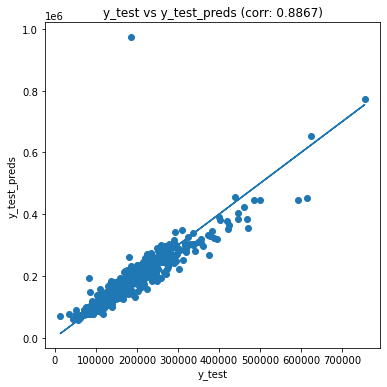

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(y=y_test_preds,x=y_test)
plt.plot(y_test,y_test)
cor = np.corrcoef(y_test_preds,y_test)
plt.xlabel('y_test')
plt.ylabel('y_test_preds')
plt.title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})");

---

## Submission

In [83]:
# Read training dataset into df
test = pd.read_csv('./datasets/test.csv')

In [84]:
test.shape

(733, 81)

In [85]:
test.isnull().mean()[test.isnull().mean()>0]

Lot Frontage      0.174625
Alley             0.924966
Mas Vnr Type      0.001364
Mas Vnr Area      0.001364
Bsmt Qual         0.017735
Bsmt Cond         0.017735
Bsmt Exposure     0.019100
BsmtFin Type 1    0.017735
BsmtFin Type 2    0.017735
Bsmt Full Bath    0.001364
Bsmt Half Bath    0.001364
Fireplace Qu      0.485675
Garage Type       0.050477
Garage Yr Blt     0.050477
Garage Finish     0.050477
Garage Qual       0.050477
Garage Cond       0.050477
Pool QC           0.998636
Fence             0.791269
Misc Feature      0.964529
dtype: float64

In [86]:
# Create a dictionary to rename columns
col_name_dict = {'Order':'id', 'PID':'pid', 'MS SubClass':'ms_subclass', 'MS Zoning':'ms_zoning',
                 'Lot Frontage':'lot_frontage', 'Lot Area':'lot_area','Street':'street','Alley':'alley',
                 'Lot Shape':'lot_shape', 'Land Contour':'land_contour', 'Utilities':'utilities',
                 'Lot Config':'lot_config', 'Land Slope':'land_slope', 'Neighborhood':'neighborhood',
                 'Condition 1':'condition_1','Condition 2':'condition_2', 'Bldg Type':'building_type',
                 'House Style':'house_style', 'Overall Qual':'overall_quality','Overall Cond':'overall_condition',
                 'Year Built':'year_built', 'Year Remod/Add':'year_remodel_add', 'Roof Style':'roof_style',
                 'Roof Matl':'roof_material', 'Exterior 1st':'exterior_1', 'Exterior 2nd':'exterior_2',
                 'Mas Vnr Type':'masonry_type','Mas Vnr Area':'masonry_area', 'Exter Qual':'external_quality',
                 'Exter Cond':'external_condition', 'Foundation':'foundation', 'Bsmt Qual':'basement_quality',
                 'Bsmt Cond':'basement_condition', 'Bsmt Exposure':'basement_exposure',
                 'BsmtFin Type 1':'basement_fin_type_1', 'BsmtFin SF 1':'basement_fin_sf_1',
                 'BsmtFin Type 2':'basement_fin_type_2', 'BsmtFin SF 2':'basement_fin_sf_2',
                 'Bsmt Unf SF':'basement_unf_sf', 'Total Bsmt SF':'total_basement_sf','Heating':'heating',
                 'Heating QC':'heating_qc', 'Central Air':'central_air', 'Electrical':'electrical',
                 '1st Flr SF':'1st_floor_sf','2nd Flr SF':'2nd_floor_sf', 'Low Qual Fin SF':'low_quality_fin_sf',
                 'Gr Liv Area':'ground_living_area', 'Bsmt Full Bath':'basement_full_bath',
                 'Bsmt Half Bath':'basement_half_bath', 'Full Bath':'full_bath', 'Half Bath':'half_bath',
                 'Bedroom AbvGr':'bed_above_ground','Kitchen AbvGr':'kitchen_above_ground',
                 'Kitchen Qual':'kitchen_quality', 'TotRms AbvGrd':'total_rooms_above_ground', 
                 'Functional':'functional','Fireplaces':'fireplace', 'Fireplace Qu':'fireplace_quality',
                 'Garage Type':'garage_type', 'Garage Yr Blt':'garage_year_built','Garage Finish':'garage_fin',
                 'Garage Cars':'garage_cars', 'Garage Area':'garage_area', 'Garage Qual':'garage_quality',
                 'Garage Cond':'garage_condition', 'Paved Drive':'paved_drive', 'Wood Deck SF':'wood_deck_sf',
                 'Open Porch SF':'open_porch_df','Enclosed Porch':'enclosed_porch', '3Ssn Porch':'3ssn_porch',
                 'Screen Porch':'screen_porch', 'Pool Area':'pool_area', 'Pool QC':'pool_quality','Fence':'fence',
                 'Misc Feature':'misc_feature', 'Misc Val':'misc_value', 'Mo Sold':'month_sold',
                 'Yr Sold':'year_sold', 'Sale Type':'sale_type','SalePrice':'sale_price'}

In [87]:
# rename columns
test = test.rename(columns=col_name_dict)

In [88]:
# Drop almost empty columns
test = test.drop(['pool_quality','alley','misc_feature','fence'], axis=1)

In [89]:
# Fill categorical column with NA

test['masonry_area'].fillna(0,inplace=True)
test['masonry_type'].fillna('None',inplace=True)
test['lot_frontage'].fillna(df['lot_frontage'].mean(),inplace=True)
test['fireplace_quality'].fillna('NA',inplace=True)
test['garage_type'].fillna('NA',inplace=True)
test['garage_year_built'].fillna(test['year_built'],inplace=True)
test['garage_fin'].fillna('Unf',inplace=True)
test['garage_quality'].fillna('NA',inplace=True)
test['garage_condition'].fillna('NA',inplace=True)
test['basement_quality'].fillna('NA',inplace=True)
test['basement_condition'].fillna('NA',inplace=True)
test['basement_exposure'].fillna('NA',inplace=True)
test['basement_fin_type_1'].fillna('NA',inplace=True)
test['basement_fin_type_2'].fillna('NA',inplace=True)
test['basement_fin_sf_1'].fillna(0,inplace=True) #mode
test['basement_fin_sf_2'].fillna(0,inplace=True) #mode
test['basement_unf_sf'].fillna(0,inplace=True) #mode
test['basement_full_bath'].fillna(0,inplace=True)
test['basement_half_bath'].fillna(0,inplace=True)
test['garage_cars'].fillna(0,inplace=True)
test['electrical'].fillna(df['electrical'].mode()[0],inplace=True)
test['total_basement_sf'].fillna(0,inplace=True)
test['garage_area'].fillna(0,inplace=True)

In [90]:
test['year_built'] = test['year_built'].apply(lambda x : str(x))

In [91]:
test['year_sold'] = test['year_sold'].apply(lambda x : str(x))

In [92]:
# Separate to numerical column
test_num = test.select_dtypes(exclude=object)

In [93]:
test_feature = list(test_num.columns)

In [94]:
test_poly = test_num

In [95]:
poly = PolynomialFeatures(include_bias=False) 
test_poly = poly.fit_transform(test_poly)

In [96]:
test_poly = pd.DataFrame(test_poly,columns=poly.get_feature_names_out(test_feature))

In [97]:
X_test = test_poly[list(poly_df.corr()[['sale_price']].sort_values('sale_price',ascending=False)[2:num_feat].index)]

In [98]:
X_test.columns

Index(['overall_quality ground_living_area', 'overall_quality^2',
       'overall_quality garage_cars', 'overall_quality garage_year_built',
       'overall_quality year_remodel_add', 'overall_quality garage_area',
       'overall_quality', 'ground_living_area garage_cars',
       'overall_quality 1st_floor_sf',
       'overall_quality total_rooms_above_ground',
       ...
       'fireplace garage_year_built', '1st_floor_sf bed_above_ground',
       'overall_condition masonry_area', 'year_remodel_add fireplace',
       'basement_fin_sf_1 total_rooms_above_ground',
       'lot_frontage total_basement_sf', 'total_rooms_above_ground',
       'kitchen_above_ground garage_cars', 'garage_cars wood_deck_sf',
       'fireplace'],
      dtype='object', length=120)

In [99]:
X_test['external_quality'] = test['external_quality']
X_test['heating_qc'] = test['heating_qc']
X_test['heating_qc'] = X_test['heating_qc'].apply(lambda x : 'Fa' if x == 'Po' else x)
X_test['kitchen_quality'] = test['kitchen_quality']
X_test['garage_fin'] = test['garage_fin']

In [100]:
list(X_test.select_dtypes(include='object').columns)

['external_quality', 'heating_qc', 'kitchen_quality', 'garage_fin']

In [101]:
X_test = pd.get_dummies(columns=list(X_test.select_dtypes(include='object').columns), data = X_test, drop_first=True)

In [102]:
## dummied category only in train data
for col in set(X.columns) - set(X_test.columns):
    X_test[col] = 0
    
## dummied category only in test data
for col in set(X_test.columns) - set(X.columns):
    X_test.drop(col, axis=1, inplace=True)

In [103]:
# predict
y_preds = lr.predict(X_test)

In [104]:
## create dataframe with "Order" and prediction
pred_df = pd.DataFrame({'Order':test['id'], 'SalePrice':y_preds})
pred_df

,Order,SalePrice
0,2127,114226.969061
1,193,210397.970617
2,2407,189851.731892
3,46,213504.681446
4,2478,192039.567245
...,...,...
728,453,199300.675778
729,1352,175176.285457
730,197,134810.299392
731,2850,170716.181666


In [105]:
## save to csv file for submission
## index = False
pred_df.to_csv('submission.csv', index=False)

----